In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append("/home/beast/Desktop/vlassis/retrieval2/experiments")

import torch
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from diffusers.optimization import get_cosine_schedule_with_warmup

from scripts.dataset import Items3Dataset, Warehouse4Dataset, warehouse4_collate_fn 
from scripts.visualization import quick_vis, quick_vis_with_parts, quick_vis_many
from scripts.visualization import quick_vis_with_arrows, rotation_matrix_from_vectors_batch
from scripts.visualization import create_arrow, create_arrows, coord_frame
from scripts.model import *
from scripts.logger import LivePlot
from scripts.metrics import AccuracyMultiClass
from scripts.utils import map_labels, generate_label_map, normalize_parts, normalize_parts_1
from scripts.utils import normalize_and_split, subsample_parts, split_into_parts_without_padding
from scripts.extensions import chamfer_dist
import math
import time

from IPython.display import display, clear_output

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Chamfer Hinge Loss

In [2]:
class ChamferDistHingeLoss():
    
    def __init__(self, dmin, dmax, Tsamples, num_steps):
        self.dmin = dmin
        self.dmax = dmax
        self.num_steps = num_steps
        self.Tsamples = Tsamples
        self.counter = 0
        self.criterion = chamfer_dist.ChamferDistanceL2_nomean()
        
        if self.num_steps != len(Tsamples):
            raise ValueError(f"The number of Tsamples must match 'num_steps'. Got: {len(Tsamples)}, {self.num_steps} instead.")
    
        self.T = self.Tsamples[self.counter]
    
    def step(self):
        self.counter = (self.counter + 1) % len(self.Tsamples)
        self.T = self.Tsamples[self.counter]
    
    @torch.no_grad()
    def f(self, x):
        return 1 - (torch.exp(self.T * x) - torch.exp(self.T * self.dmin)) / (torch.exp(self.T * self.dmax) - torch.exp(self.T * self.dmin))
    
    @property
    def samples(self):
        return self.f(torch.arange(self.dmin, self.dmax, (self.dmax - self.dmin) / 100))
    
    def state_dict(self):
        
        return {
            "dmin": self.dmin, "dmax": self.dmax, "num_steps": self.num_steps,
            "samples": self.Tsamples, "counter": self.counter
        }
    
    def load_state_dict(self, sd):
        
        self.dmin = sd["dmin"]
        self.dmax = sd["dmax"]
        self.num_steps = sd["num_steps"]
        self.Tsamples = sd["samples"]
        self.counter = sd["counter"]    
    
    @torch.no_grad()
    def __call__(self, parts, pid, vectors):
        

        '''
            parts: torch.Tensor(N x 3)
            pid: torch.Tensor(N)
            vectors: torch.Tensor(M x 3)
        '''
        
        #splitting into parts and padding 1 x Ntot x 3 -> M x Nmax x 3
        pad_point = torch.Tensor([0, 0, 0]).to(parts.device)
        parts, point_mask = split_into_parts_without_padding(parts.unsqueeze(0), pid.unsqueeze(0), pad_point)
        M = vectors.shape[0]
        
        #normalizing the scale (try without scale normalization to take size into account as well)
        max_abs = (parts * parts).sum(dim=-1).max(dim=-1).values.sqrt()
        max_abs[max_abs == 0] = 1 #setting 0 values to 1 to avoid NaNs
        parts /= max_abs.reshape(-1, 1, 1)
        
        #         #setting the target vectors to be the z-axis
        #         v_target = torch.Tensor([[0,0,1]]).repeat(M, 1).to(parts.device)

        #         #calculating relative rotations
        #         R = rotation_matrix_from_vectors_batch(vectors, v_target)

        #         #multiplying the parts by the rotation matrices
        #         parts = (R.unsqueeze(1) @ parts.unsqueeze(-1)).squeeze()
        #         vectors = (R @ vectors.unsqueeze(-1).float()).squeeze()
    
        #replacing the old pad point with a far away point
        #only after normalization and rotation
        idx = (parts == pad_point).all(dim=-1)
        parts[idx] = torch.Tensor([100, 100, 100]).to(parts.device)
    
        #repeating for all-to-all calculation
        parts1 = parts.repeat(M, 1, 1)
        parts2 = parts.repeat_interleave(M, dim=0)
        
        #distance calculation
        d1, d2 = self.criterion(parts1, parts2)
        m1, m2 = point_mask.repeat(M, 1), point_mask.repeat_interleave(M, dim=0)
    
        #mean calculation that ignores padded elements
        d1 = (d1 * m1).sum(dim=-1) / m1.sum(dim=-1)
        d2 = (d2 * m2).sum(dim=-1) / m2.sum(dim=-1)
    
        #reshaping into square matrix
        d1 = d1.reshape(M, M)
        d2 = d2.reshape(M, M)
        
        #mean between distances from both directions
        d = (d1 + d2) / 2
        
        #hinge loss calculation
        hinge = 1 - (torch.exp(self.T*d) - math.exp(self.dmin*self.T)) / (math.exp(self.T*self.dmax) - math.exp(self.dmin*self.T))

        
        return hinge

### Data & Model

In [3]:
def save_checkpoint(path, model, optimizer, scheduler, logger, criterion, seed,
                   num_epochs, batch_size):
    
    state_dict = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "logger": logger.state_dict(),
        "criterion": criterion.state_dict(),
        "seed": seed,
        "num_epochs": num_epochs,
        "batch_size": batch_size
    }
    
    torch.save(state_dict, path)

def load_checkpoint(path):
    
    sd = torch.load(path)
    
    return sd["model"], sd["optimizer"], sd["scheduler"], sd["logger"], sd["criterion"], sd["seed"], sd["num_epochs"], sd["batch_size"]

In [4]:
seed = 42
torch.manual_seed(seed)

# data_path = "/home/beast/Desktop/vlassis/retrieval2/experiments/data/vectors_warehouse_partnet2/"
data_path = "/home/beast/Desktop/vlassis/retrieval2/experiments/data/vectors_warehouse_shapenet/"

#data
batch_size = 192
categories = [0,4,15] #[0, 1, 3]
dataset = Warehouse4Dataset(cat=None, path = data_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                       collate_fn = warehouse4_collate_fn, drop_last=True)

#model
model = PartFinderPipeline2(in_channels = 3, out_channels = 384,
                            num_classes = len(categories),
                            num_attention_blocks = 3,
                            pos_emb_dim = 3,
                            pool_method = "cls_token_pool"
                           ).cuda()


#training params
num_epochs = 100
num_steps = len(dataloader) * num_epochs
lr, warmup_steps = 1e-4, 100
current_epoch = 0

#initialize optimizer
opt = torch.optim.Adam(model.encoder.parameters(), lr=lr)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = opt,
    num_warmup_steps = warmup_steps,
    num_training_steps = num_steps
)

#logger
loggerconfig = {
    "on_step": [{"Loss per step": "Loss"}],
    "on_epoch":[{"Loss per epoch": "Loss"}],
    "on_update": [{"Task difficulty": "Hinge"}]            
}
logger = LivePlot(loggerconfig)

#loss function
# Tmin, Tmax = 0.1, 14
# T_samples = torch.arange(Tmin, Tmax, (Tmax - Tmin) / num_steps)
Tfixed = 7
T_samples = torch.ones(num_steps) * Tfixed
criterion = ChamferDistHingeLoss(0, 0.6, T_samples, num_steps)

#
LOAD_CHECKPOINT = False
checkpoint_path = ""

if LOAD_CHECKPOINT:
    modelsd, optimizersd, schedulersd, loggersd, criterionsd, seed, num_epochs, batch_size = load_checkpoint(checkpoint_path)
    
    model.load_state_dict(modelsd)
    opt.load_state_dict(optimizersd)
    lr_scheduler.load_state_dict(schedulersd)
    logger.load_state_dict(loggersd)
    criterion.load_state_dict(criterionsd)
    torch.manual_seed(seed)


Initializing warehouse dataset
Warehouse dataset initialization complete (t = 0.14966750144958496)


### Training Loop

In [5]:
def train_epoch(model, dataloader, opt, lr_scheduler, criterion, logger):
    
    model.train()
    
    epoch_loss = 0.0
    steps = 0
    global batch_size
    
    found_nan = False
         
    for shape, _, part_labels, vectors in dataloader:

        opt.zero_grad()
        
        #normalizing the parts
        parts = [p - p.mean(dim=0) for p in shape]
        pid = torch.cat([torch.ones(p.shape[0], dtype=torch.int32) * i for i, p in enumerate(parts)])
        parts = torch.cat(parts).float()
        
        #passing data to gpu
        parts, part_labels, pid, vectors = parts.cuda(), part_labels.cuda(), pid.cuda(), vectors.cuda()

        #running the model - M' x F
        part_feats = model.forward_encoder(parts, pid, batch_size)
        
        #normalizing the feature vectors M' x F
        part_feats = torch.nn.functional.normalize(part_feats, p=2, dim=-1)
        
        #forming similarity matrix M' x M'
        similarity_matrix = part_feats @ part_feats.T

        #chamfer hinge criterion
        ch_dist = criterion(parts, pid, vectors)

        #forming the ground truth similarity matrix
        # part_lbs_expanded = part_labels.unsqueeze(0).repeat(part_labels.shape[0],1)
        # part_similarity_mask = part_lbs_expanded == part_lbs_expanded.T
        # gt_similarity = (part_similarity_mask.float() + ch_dist * (~part_similarity_mask).float())

        #loss calculation 
        loss = ((similarity_matrix - ch_dist)**2).mean()
    
        #back propagation
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        epoch_loss += loss.item()
        steps +=1

        #optimizer
        opt.step()
        lr_scheduler.step()

        #logger updates
        logger.on_step([loss.item()])
        logger.on_custom_update([criterion.samples])
        
        criterion.step()      
    
    return epoch_loss / steps

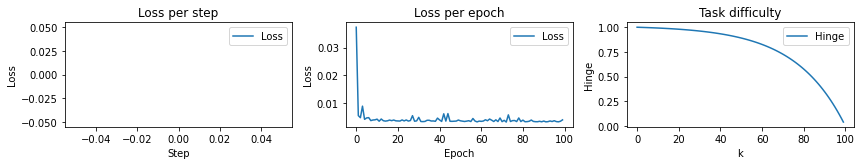

In [6]:
%matplotlib inline
for i in range(num_epochs):
    
    #save checkpoint every k epochs
    if i % 25 == 0:
        save_path = f"/home/beast/Desktop/vlassis/retrieval2/checkpoints/0415_T{Tfixed}_shapenet_{i}.pt"
        save_checkpoint(save_path, model.encoder, opt, lr_scheduler, logger, criterion, seed, num_epochs, batch_size)
    
    epoch_loss = train_epoch(model, dataloader, opt, lr_scheduler, criterion, logger)
    logger.on_epoch([epoch_loss])

In [7]:
save_path = f"/home/beast/Desktop/vlassis/retrieval2/checkpoints/0415_T{Tfixed}_shapenet.pt"
save_checkpoint(save_path, model.encoder, opt, lr_scheduler, logger, criterion, seed, num_epochs, batch_size)

### CHAMFER LOSS MATRIX VISUALIZATION

In [8]:
class ChamferDistHingeLoss():
    
    def __init__(self, dmin, dmax, Tmax, num_steps):
        self.dmin = dmin
        self.dmax = dmax
        self.num_steps = num_steps
        self.Tmax = Tmax
        
        self.T = 0.01
        self.counter = 0.0
        self.step_val = Tmax / num_steps
        self.criterion = chamfer_dist.ChamferDistanceL2_nomean()
        
        self.plot()
    
    def step(self):
        self.counter += self.step_val
        self.T = self.Tmax * self.counter / (self.counter + 1)
    
    def plot(self):
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10,2))
        plt.plot([0, self.Tmax], [0, 0], color='blue', linewidth=2, label = 'Range')
        
        x = np.linspace(0, self.Tmax, self.num_steps)
        T = self.Tmax * x / (x + 1)
        
        plt.scatter(T, np.zeros_like(T), color='red', s=10, label = 'Samples')
        plt.title("Training session T samples")
        plt.xlabel("T")
        plt.yticks([])
        plt.legend()
        plt.show()
    
    @torch.no_grad()
    def __call__(self, parts, pid, vectors):
        

        '''
            parts: torch.Tensor(N x 3)
            pid: torch.Tensor(N)
            vectors: torch.Tensor(M x 3)
        '''
        
        #CAREFUL, PADDING WITH A FAR AWAY POINT AFFECTS THE NORMALIZATION!
        print(parts.shape, pid.shape, vectors.shape)
        
        #splitting into parts and padding B x N x 3 -> M x N x 3
        pad_point = torch.Tensor([0, 0, 0]).to(parts.device)
        parts, point_mask = split_into_parts_without_padding(parts.unsqueeze(0), pid.unsqueeze(0), pad_point)
        M = vectors.shape[0]
        
        #normalizing the scale (try without scale normalization to take size into account as well)
        max_abs = (parts * parts).sum(dim=-1).max(dim=-1).values.sqrt()
        max_abs[max_abs == 0] = 1 #setting 0 values to 1 to avoid NaNs
        parts /= max_abs.reshape(-1, 1, 1)
        
        #replacing the old pad point with a far away point
        #only after normalization
        idx = torch.all(parts == torch.Tensor([0,0,0]).to(parts.device))
        parts[idx] = torch.Tensor([100,100,100]).to(parts.device)
    
        #repeating for all-to-all calculation
        parts1 = parts.repeat(M, 1, 1)
        parts2 = parts.repeat_interleave(M, dim=0)
        
        #repeating vectors to match the shapes (can delete later to save memory)
        v1 = vectors.repeat(M, 1)
        v2 = vectors.repeat_interleave(M, dim=0)
        
        #calculating relative rotations
        R = rotation_matrix_from_vectors_batch(v1, v2)
        
        #multiplying the parts by the rotation matrices
        with torch.no_grad():
            parts1 = (R.unsqueeze(1) @ parts1.unsqueeze(-1)).squeeze()
        
        #distance calculation
        d1, d2 = self.criterion(parts1, parts2)
        m1, m2 = point_mask.repeat(M, 1), point_mask.repeat_interleave(M, dim=0)
    
        #mean calculation that ignores padded elements
        d1 = (d1 * m1).sum(dim=-1) / m1.sum(dim=-1)
        d2 = (d2 * m2).sum(dim=-1) / m2.sum(dim=-1)
    
        #reshaping into square matrix
        d1 = d1.reshape(M, M)
        d2 = d2.reshape(M, M)
        
        #mean between distances from both directions
        d = (d1 + d2) / 2
        
        #hinge loss calculation
        hinge = 1 - (torch.exp(self.T*d) - math.exp(self.dmin*self.T)) / (math.exp(self.T*self.dmax) - math.exp(self.dmin*self.T))
        
        v1 = (R.double() @ v1.unsqueeze(-1)).squeeze()
        
        
        return hinge, parts1, parts2, v1, v2

(10408,)
Items2 dataset initialization complete (t = 3.2343063354492188)


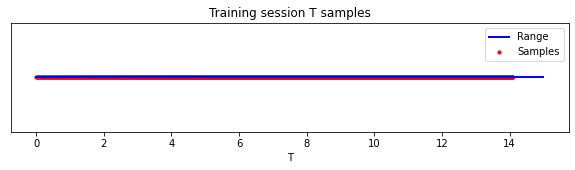

In [9]:
torch.manual_seed(42)

data_path = "/home/beast/Desktop/vlassis/retrieval2/experiments/data/vectors2_items2_partnet.h5"

#data
batch_size = 48
categories = [0, 1, 3]
dataset = Items3Dataset(cat=categories, path = data_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#
num_epochs = 50
num_parts_keep = 32

#loss function
criterion = ChamferDistHingeLoss(0, 0.6, 15, len(dataloader) * num_epochs)

In [10]:
import plotly.graph_objects as go

#grabbing a sample from the dataloader
shape, _, part_label, pid, vectors = next(iter(dataloader))

#passing data to gpu
shape, part_label, pid, vectors = shape.cuda(), part_label.cuda(), pid.cuda(), vectors.cuda()

#normalizing the parts - N x 3, N, M, M x 3
parts, pid, part_label, vectors = normalize_and_split(shape, pid, part_label, vectors)

#shuffling and grabbing a random subset N' x 3, N', M', M' x 3
parts, pid, part_label, vectors = subsample_parts(parts, pid, part_label, vectors, num_parts_keep)

#chamfer hinge criterion
ch_dist, parts1, parts2, vecs1, vecs2 = criterion(parts, pid, vectors)
ch_dist = ch_dist.cpu().detach().numpy()

fig = go.FigureWidget([
    go.Heatmap(
        z=ch_dist,
        colorscale='Viridis'
    )
])

fig.update_layout(
    autosize=False,
    width=800,  # Adjust the width as necessary
    height=800,  # Adjust the height as necessary
    margin=dict(l=80, r=80, b=80, t=80),
    xaxis=dict(scaleanchor="y", scaleratio=1)
)

def show_point_clouds(trace, points, selector):
    i, j = points.point_inds[0]
    print(f"Selected cell: ({i}, {j})")
    # Add your code to visualize the aligned point clouds i and j
    # For example, using matplotlib or plotly 3D scatter plot

    M = ch_dist.shape[0]

    pcs = [
        parts1[i * M + j],
        parts2[i * M + j]
    ]

    vecs = torch.stack((
        vecs1[i * M + j],
        vecs2[i * M + j]
    ))

    quick_vis_with_arrows(pcs, vecs, title= f"distance: {ch_dist[i, j]}")

heatmap = fig.data[0]
heatmap.on_click(show_point_clouds)

fig

ValueError: not enough values to unpack (expected 4, got 3)